# Introduction #

This lesson and the next make use of what are known as *unsupervised learning* algorithms. Unsupervised algorithms don't make use of a target; instead, their purpose is to learn some property of the data, to represent the structure of the features in a certain way. In the context of feature engineering for prediction, you could think of an unsupervised algorithm as a "feature discovery" technique.

**Clustering** simply means the assigning of data points to groups based upon how similar the points are to each other. A clustering algorithm makes "birds of a feather flock together," so to speak.

When used for feature engineering, we could attempt to discover groups of customers representing a market segment, for instance, or geographic areas that share similar weather patterns. Adding a feature of cluster labels can help machine learning models untangle complicated relationships of space or proximity.

# Cluster Labels as a Feature #

Applied to a single real-valued feature, clustering acts like a traditional "binning" or ["discretization"](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization_classification.html) transform. On multiple features, it's like "multi-dimensional binning" (sometimes called *vector quantization*).

<figure style="padding: 1em;">
<img src="https://i.imgur.com/sr3pdYI.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center><strong>Left:</strong> Clustering a single feature. <strong>Right:</strong> Clustering across two features.
</center></figcaption>
</figure>

Added to a dataframe, a feature of cluster labels might look like this:

| Longitude | Latitude | Cluster |
|-----------|----------|---------|
| -93.619   | 42.054   | 3       |
| -93.619   | 42.053   | 3       |
| -93.638   | 42.060   | 1       |
| -93.602   | 41.988   | 0       |

It's important to remember that this `Cluster` feature is categorical. Here, it's shown with a label encoding (that is, as a sequence of integers) as a typical clustering algorithm would produce; depending on your model, a one-hot encoding may be more appropriate.

The motivating idea for adding cluster labels is that the clusters will break up complicated relationships across features into simpler chunks. Our model can then just learn the simpler chunks one-by-one instead having to learn the complicated whole all at once. It's a "divide and conquer" strategy.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/rraXFed.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Clustering the YearBuilt feature helps this linear model learn its relationship to SalePrice.
</center></figcaption>
</figure>

The figure shows how clustering can improve a simple linear model. The curved relationship between the `YearBuilt` and `SalePrice` is too complicated for this kind of model -- it *underfits*. On smaller chunks however the relationship is *almost* linear, and that the model can learn easily.

# k-Means Clustering #

There are a great many clustering algorithms. They differ primarily in how they measure "similarity" or "proximity" and in what kinds of features they work with. The algorithm we'll use, k-means, is intuitive and easy to apply in a feature engineering context. Depending on your application another algorithm might be more appropriate.

**K-means clustering** measures similarity using ordinary straight-line distance (Euclidean distance, in other words). It creates clusters by placing a number of points, called **centroids**, inside the feature-space. Each point in the dataset is assigned to the cluster of whichever centroid it's closest to. The "k" in "k-means" is how many centroids (that is, clusters) it creates. You define the k yourself.

You could imagine each centroid capturing points through a sequence of radiating circles. When sets of circles from competing centroids overlap they form a line. The result is what's called a **Voronoi tessallation**. The tessallation shows you to what clusters future data will be assigned; the tessallation is essentially what k-means learns from its training data.

The clustering on the [*Ames*](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset above is a k-means clustering. Here is the same figure with the tessallation and centroids shown.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/KSoLd3o.jpg.png" width=450, alt="">
<figcaption style="textalign: center; font-style: italic"><center>K-means clustering creates a Voronoi tessallation of the feature space.
</center></figcaption>
</figure>

Let's review how the k-means algorithm learns the clusters and what that means for feature engineering. We'll focus on three parameters from scikit-learn's implementation: `n_clusters`, `max_iter`, and `n_init`.

It's a simple two-step process. The algorithm starts by randomly initializing some predefined number (`n_clusters`) of centroids. It then iterates over these two operations:
1. assign points to the nearest cluster centroid
2. move each centroid to minimize the distance to its points

It iterates over these two steps until the centroids aren't moving anymore, or until some maximum number of iterations has passed (`max_iter`).

It often happens that the initial random position of the centroids ends in a poor clustering. For this reason the algorithm repeats a number of times (`n_init`) and returns the clustering that has the least total distance between each point and its centroid, the optimal clustering.

The animation below shows the algorithm in action. It illustrates the dependence of the result on the initial centroids and the importance of iterating until convergence.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/tBkCqXJ.gif" width=550, alt="">
<figcaption style="textalign: center; font-style: italic"><center>The K-means clustering algorithm on Airbnb rentals in NYC.
</center></figcaption>
</figure>

You may need to increase the `max_iter` for a large number of clusters or `n_init` for a complex dataset. Ordinarily though the only parameter you'll need to choose yourself is `n_clusters` (k, that is). The best partitioning for a set of features depends on the model you're using and what you're trying to predict, so it's best to tune it like any hyperparameter (through cross-validation, say).

# Example - California Housing #

As spatial features, [*California Housing*](https://www.kaggle.com/camnugent/california-housing-prices)'s `'Latitude'` and `'Longitude'` make natural candidates for k-means clustering. In this example we'll cluster these with `'MedInc'` (median income) to create economic segments in different regions of California.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

df = pd.read_csv("../input/fe-course-data/housing.csv")
X = df.loc[:, ["MedInc", "Latitude", "Longitude"]]
X.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


Since k-means clustering is sensitive to scale, it can be a good idea rescale or normalize data with extreme values. Our features are already roughly on the same scale, so we'll leave them as-is.

In [2]:
# Create cluster feature
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

,MedInc,Latitude,Longitude,Cluster
0,8.3252,37.88,-122.23,1
1,8.3014,37.86,-122.22,1
2,7.2574,37.85,-122.24,1
3,5.6431,37.85,-122.25,1
4,3.8462,37.85,-122.25,4


Now let's look at a couple plots to see how effective this was. First, a scatter plot that shows the geographic distribution of the clusters. It seems like the algorithm has created separate segments for higher-income areas on the coasts.

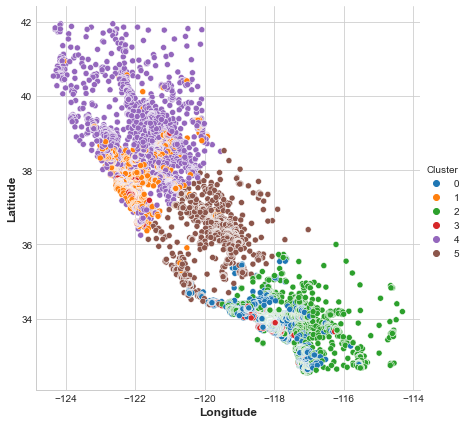

In [3]:
sns.relplot(
    x="Longitude", y="Latitude", hue="Cluster", data=X, height=6,
);

The target in this dataset is `MedHouseVal` (median house value). These box-plots show the distribution of the target within each cluster. If the clustering is informative, these distributions should, for the most part, separate across `MedHouseVal`, which is indeed what we see.

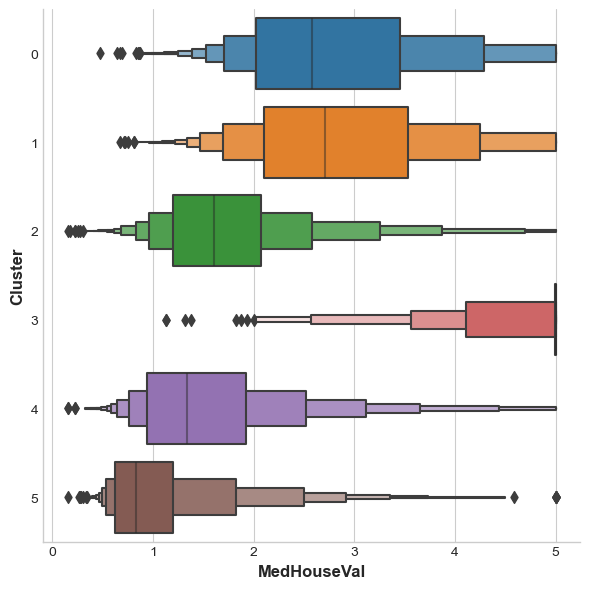

In [4]:
X["MedHouseVal"] = df["MedHouseVal"]
sns.catplot(x="MedHouseVal", y="Cluster", data=X, kind="boxen", height=6);

# Your Turn #

[**Add a feature of cluster labels**](./4-exercise-clustering-with-k-means.ipynb) to *Ames* and learn about another kind of feature clustering can create.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*